### Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import json
import os
import random
from pathlib import Path
import subprocess
from typing import Tuple, Optional, NamedTuple

# Import third-party libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import SVG
from matplotlib import patches, pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from tqdm.auto import tqdm

# Import ONNX
import onnx

# Import Hailo SDK dependencies
from hailo_sdk_client import ClientRunner, InferenceContext, CalibrationDataType
from hailo_sdk_client.exposed_definitions import SUPPORTED_HW_ARCHS

# Import utility functions (assuming these are custom modules)
from cjm_psl_utils.core import download_file, file_extract
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_pil_utils.annotation import draw_bboxes

2024-10-14 18:18:22.498944: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 18:18:22.500126: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 18:18:22.526515: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 18:18:22.527007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 18:18:22.918302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Setting Up the Project

### Set the Directory Paths

In [3]:
# The name for the project
project_name = f"pytorch-yolox-object-detector"

# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# The path to the checkpoint folder
checkpoint_dir = Path(project_dir/f"2024-09-08_19-22-32")

pd.Series({
    "Project Directory:": project_dir,
    "Checkpoint Directory:": checkpoint_dir,
}).to_frame().style.hide(axis='columns')

Project Directory:,pytorch-yolox-object-detector
Checkpoint Directory:,pytorch-yolox-object-detector/2024-09-08_19-22-32


### Download a Font File

In [4]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


## Loading the Checkpoint Data

### Load the Colormap

In [5]:
# The colormap path
colormap_path = list(checkpoint_dir.glob('*colormap.json'))[0]

# Load the JSON colormap data
with open(colormap_path, 'r') as file:
        colormap_json = json.load(file)

# Convert the JSON data to a dictionary        
colormap_dict = {item['label']: item['color'] for item in colormap_json['items']}

# Extract the class names from the colormap
class_names = list(colormap_dict.keys())

# Make a copy of the colormap in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colormap_dict.values()]

### Set Model Checkpoint Information

In [6]:
# The onnx model path
onnx_file_path = list(checkpoint_dir.glob('*.onnx'))[0]

# Set max stride value for processing output
max_stride = 32

### Parsing

#### Initialize a Dataflow Compiler API client

In [7]:
# Display supported hardware architectures
SUPPORTED_HW_ARCHS

['hailo8',
 'hailo8r',
 'hailo8l',
 'hailo15h',
 'hailo15m',
 'hailo15l',
 'hailo10h']

In [8]:
# Initialize a Dataflow Compiler API client
runner = ClientRunner(hw_arch="hailo8l")

#### Selecting an Input Resolution

In [9]:
# Set the input resolution for the model
input_sz = (512, 288)

#### Parse the ONNX Model

In [10]:
# Parse the ONNX Model
# This step translates the ONNX model to a format compatible with Hailo hardware
hn, npz = runner.translate_onnx_model(
    str(onnx_file_path),
    onnx_file_path.stem,  # Use the filename (without extension) as the model name
    start_node_names=["input"],  # Specify the input node name
    end_node_names=['output'],  # Specify the output node name
    net_input_shapes={"input": [1, 3, *input_sz[::-1]]},  # Define input shape: [batch_size, channels, height, width]
)

[info] Translation started on ONNX model hagrid-sample-30k-384p-yolox_tiny
[info] Restored ONNX model hagrid-sample-30k-384p-yolox_tiny (completion time: 00:00:00.06)
[info] Extracted ONNXRuntime meta-data for Hailo model (completion time: 00:00:00.18)
[info] NMS structure of yolox (or equivalent architecture) was detected.
[info] In order to use HailoRT post-processing capabilities, these end node names should be used: /Sigmoid /Sigmoid_1 /model/bbox_head/multi_level_conv_reg.0/Conv /Sigmoid_2 /Sigmoid_3 /model/bbox_head/multi_level_conv_reg.1/Conv /Sigmoid_4 /Sigmoid_5 /model/bbox_head/multi_level_conv_reg.2/Conv.
[info] Start nodes mapped from original model: 'input': 'hagrid-sample-30k-384p-yolox_tiny/input_layer1'.
[info] End nodes mapped from original model: '/Transpose'.
[info] Translation completed on ONNX model hagrid-sample-30k-384p-yolox_tiny (completion time: 00:00:00.68)


#### Inspect HAR Output Shape

In [11]:
# Get input and output shapes from the Hailo Archive (HAR)
har_input_shape = runner.get_hn_dict()['layers']['hagrid-sample-30k-384p-yolox_tiny/input_layer1']['input_shapes'][0]
har_output_shape = runner.get_hn_dict()['layers']['hagrid-sample-30k-384p-yolox_tiny/output_layer1']['output_shapes'][0]

# Load the original ONNX model
onnx_model = onnx.load_model(onnx_file_path)

# Extract input and output shapes from the ONNX model
onnx_input_shape = [dim.dim_value for dim in onnx_model.graph.input[0].type.tensor_type.shape.dim]
onnx_output_shape = [dim.dim_value for dim in onnx_model.graph.output[0].type.tensor_type.shape.dim]

# Create a DataFrame to compare ONNX and HAR shapes
pd.DataFrame({"ONNX": {"input_shape:":onnx_input_shape, "output_shape:": onnx_output_shape},
              "HAR": {"input_shape:":har_input_shape, "output_shape:": har_output_shape}})

,ONNX,HAR
input_shape:,"[1, 3, 0, 0]","[-1, 288, 512, 3]"
output_shape:,"[1, 0, 24]","[-1, 1, 24, 3024]"


#### Save the Hailo Archive

In [12]:
# Save the Hailo Archive (HAR) file
hailo_model_har_name = f"{onnx_file_path.stem}_hailo_model.har"
hailo_model_har_path = onnx_file_path.parent/hailo_model_har_name
runner.save_har(hailo_model_har_path)

[info] Saved HAR to: /mnt/ACASIS_4TB/Projects/GitHub/pytorch-yolox-object-detection-tutorial-code/notebooks/pytorch-yolox-object-detector/2024-09-08_19-22-32/hagrid-sample-30k-384p-yolox_tiny_hailo_model.har


#### Visualize the Graph Structure

In [13]:
# Visualize the Graph Structure
!hailo visualizer {hailo_model_har_path} --no-browser

[info] Current Time: 18:18:30, 10/14/24
[info] CPU: Architecture: x86_64, Model: 11th Gen Intel(R) Core(TM) i7-11700K @ 3.60GHz, Number Of Cores: 16, Utilization: 1.7%
[info] Memory: Total: 31GB, Available: 17GB
[info] System info: OS: Linux, Kernel: 6.8.0-45-generic
[info] Hailo DFC Version: 3.29.0
[info] HailoRT Version: Not Installed
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo visualizer pytorch-yolox-object-detector/2024-09-08_19-22-32/hagrid-sample-30k-384p-yolox_tiny_hailo_model.har --no-browser`


### Model Optimization

#### Set the Dataset Path

In [14]:
# Define path to store datasets
dataset_dir = Path("/mnt/Storage/Datasets")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Set the name of the dataset
dataset_name = 'hagrid-sample-30k-384p'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/hagrid-sample-30k-384p
Archive Path:,/mnt/Storage/Datasets/../Archive/hagrid-sample-30k-384p.zip
Dataset Path:,/mnt/Storage/Datasets/hagrid-sample-30k-384p


#### Download the Dataset

In [15]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/hagrid-sample-30k-384p/resolve/main/hagrid-sample-30k-384p.zip
Dataset folder already exists


#### Get Image File Paths

In [16]:
# Get a list of all JPG image files in the dataset
img_file_paths = list(dataset_path.glob("./**/*.jpg"))

# Print the number of image files
print(f"Number of Images: {len(img_file_paths)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame(img_file_paths).head()

Number of Images: 31833


,0
0,/mnt/Storage/Datasets/hagrid-sample-30k-384p/h...
1,/mnt/Storage/Datasets/hagrid-sample-30k-384p/h...
2,/mnt/Storage/Datasets/hagrid-sample-30k-384p/h...
3,/mnt/Storage/Datasets/hagrid-sample-30k-384p/h...
4,/mnt/Storage/Datasets/hagrid-sample-30k-384p/h...


#### Select Sample Images

In [17]:
random.seed(1234) # Set random seed for consistency 
sample_img_paths = random.sample(img_file_paths, 1024)

#### Define a Preprocessing Function

In [18]:
def preproc(image, output_height, output_width, resize_side):
    """
    This function resizes the input image while maintaining its aspect ratio,
    crops (or pads) it to the desired output size, and normalizes pixel values
    to the range [0, 1].

    Parameters:
        image (PIL.Image.Image or np.ndarray): The input image to preprocess.
        output_height (int): The desired output height of the image.
        output_width (int): The desired output width of the image.
        resize_side (int): The size to which the smallest side of the image is resized.

    Returns:
        np.ndarray: The preprocessed image as a NumPy array of shape (output_height, output_width, 3),
                    with pixel values normalized to the range [0, 1].
    """

    # Ensure the image is a NumPy array
    if isinstance(image, Image.Image):
        # Convert PIL Image to NumPy array
        image = np.array(image)

    # Get the original image dimensions
    h, w = image.shape[:2]  # h = height, w = width

    # Calculate the scaling factor to resize the image
    # We want the smallest side to be 'resize_side' pixels
    scale = resize_side / min(h, w)

    # Compute the new image dimensions after resizing
    new_h = int(h * scale)
    new_w = int(w * scale)

    # Resize the image using bilinear interpolation for smoother results
    # Convert the NumPy array back to a PIL Image for resizing
    resized_image = Image.fromarray(image).resize((new_w, new_h), Image.BILINEAR)

    # Convert the resized image back to a NumPy array
    resized_image = np.array(resized_image)

    # Calculate coordinates for center cropping
    # We want to crop the center 'output_height' x 'output_width' area
    top = (new_h - output_height) // 2  # Starting y-coordinate
    left = (new_w - output_width) // 2  # Starting x-coordinate
    bottom = top + output_height        # Ending y-coordinate
    right = left + output_width         # Ending x-coordinate

    # Check if we need to pad the image (if the crop area extends beyond the image boundaries)
    if top < 0 or left < 0:
        # Calculate how much padding is needed on each side
        pad_top = max(0, -top)                # Positive value indicates padding needed
        pad_bottom = max(0, bottom - new_h)   # Padding needed at the bottom
        pad_left = max(0, -left)              # Padding needed on the left
        pad_right = max(0, right - new_w)     # Padding needed on the right

        # Pad the image with zeros (black pixels) on each side
        # The padding tuple format is ((top, bottom), (left, right), (channel_start, channel_end))
        resized_image = np.pad(
            resized_image,
            pad_width=((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
            mode='constant',
            constant_values=0
        )

        # After padding, update the crop coordinates to the padded image
        top = pad_top
        left = pad_left
        bottom = top + output_height
        right = left + output_width

    # Crop the image to the desired output size
    # This will extract the central region of the image
    cropped_image = resized_image[top:bottom, left:right]

    # Normalize pixel values to the range [0, 1]
    # Convert pixel values to float32 and divide by 255
    normalized_image = cropped_image.astype(np.float32) / 255.0

    # Return the preprocessed image
    return normalized_image

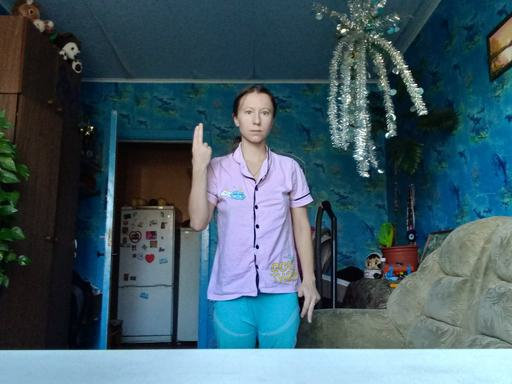

In [19]:
# Select a sample image
sample_img = Image.open(sample_img_paths[0])
sample_img

processed_inp.shape: (288, 512, 3)


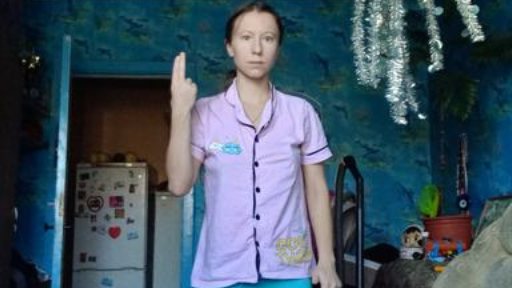

In [20]:
# Process the sample image
img_preproc_np = preproc(sample_img, output_height=input_sz[1], output_width=input_sz[0], resize_side=input_sz[0])
print(f"processed_inp.shape: {img_preproc_np.shape}")
# Visualize the processed sample image
Image.fromarray((img_preproc_np*255).astype(np.uint8))

#### Generate a Calibration Dataset

In [21]:
# Create an empty numpy array to store the calibration dataset
# Shape: (number of images, height, width, color channels)
calib_dataset = np.zeros((len(sample_img_paths), input_sz[1], input_sz[0], 3), dtype=np.float32)

# Iterate through each image path in the sample_img_paths list
for idx, img_path in enumerate(tqdm(sample_img_paths)):
    # Open and read the image file
    img = np.array(Image.open(img_path))
    
    # Preprocess the image
    img_preproc_np = preproc(img, output_height=input_sz[1], output_width=input_sz[0], resize_side=input_sz[0])
    
    # Store the preprocessed image in the calibration dataset
    calib_dataset[idx, :, :, :] = img_preproc_np

  0%|          | 0/1024 [00:00<?, ?it/s]

#### Initialize a Hailo Dataflow Compiler API Client

In [22]:
# By default it uses the hw_arch that is saved on the HAR. For overriding, use the hw_arch flag.
runner = ClientRunner(har=str(hailo_model_har_path))

#### Quantize the Hailo Archive

In [23]:
# Create a model script that tells the compiler to add a normalization on the beginning of the model
# alls = "normalization1 = normalization([0.5, 0.5, 0.5], [1.0, 1.0, 1.0])\n"
alls = ""

# Load the model script to ClientRunner so it will be considered on optimization
# runner.load_model_script(alls)

# Call Optimize to perform the optimization process
runner.optimize(calib_dataset)

[info] Starting Model Optimization


2024-10-14 18:18:37.828348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-14 18:18:37.857490: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-14 18:18:37.974806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

[warning] Reducing optimization level to 0 (the accuracy won't be optimized and compression won't be used) because there's no available GPU
[warning] Running model optimization with zero level of optimization is not recommended for production use and might lead to suboptimal accuracy results
[info] Model received quantization params from the hn
[info] Starting Mixed Precision
[info] Mixed Precision is done (completion time is 00:00:00.42)
[info] LayerNorm Decomposition skipped
[info] Starting Statistics Collector
[info] Using dataset with 64 entries for calibration


Calibration:   0%|                                                            | 0/64 [00:00<?, ?entries/s]2024-10-14 18:18:45.128996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-10-14 18:18:45.146841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,288,512,3]
	 [[{{node Placeholder/_0}}]]
Calibration:   2%|▊                                                   | 1/64 [00:17<18:45, 17.87s/entries]2024-10-14 18:18:59.589723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Exec

[info] Statistics Collector is done (completion time is 00:00:21.52)
[info] Starting Fix zp_comp Encoding
[info] Fix zp_comp Encoding is done (completion time is 00:00:00.00)
[info] Matmul Equalization skipped
[info] No shifts available for layer hagrid-sample-30k-384p-yolox_tiny/conv79/conv_op, using max shift instead. delta=0.0653
[info] No shifts available for layer hagrid-sample-30k-384p-yolox_tiny/conv79/conv_op, using max shift instead. delta=0.0327
[info] Finetune encoding skipped
[info] Bias Correction skipped
[info] Adaround skipped
[info] Quantization-Aware Fine-Tuning skipped
[info] Layer Noise Analysis skipped
[info] The calibration set seems to not be normalized, because the values range is [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)].
Since the neural core works in 8-bit (between 0 to 255), a quantization will occur on the CPU of the runtime platform.
Add a normalization layer to the model to offload the normalization to the neural core.
Refer to the user guide Hailo Dataflow Com

#### Save the Quantized Hailo Archive

In [24]:
# Save the result state to a Quantized HAR file
quantized_model_har_path = onnx_file_path.parent/f"{onnx_file_path.stem}_quantized_model.har"
runner.save_har(quantized_model_har_path)

[info] Saved HAR to: /mnt/ACASIS_4TB/Projects/GitHub/pytorch-yolox-object-detection-tutorial-code/notebooks/pytorch-yolox-object-detector/2024-09-08_19-22-32/hagrid-sample-30k-384p-yolox_tiny_quantized_model.har


#### Define Functions to Handle Arbitrary Input Resolutions 

In [25]:
class ImageTransformData(NamedTuple):
    """
    A data class that stores transformation information applied to an image.

    Attributes:
        offset (Tuple[int, int]): The (x, y) offset where the resized image was pasted.
        scale (float): The scaling factor applied to the original image.
    """
    offset: Tuple[int, int]
    scale: float

def resize_and_pad(
    image: Image.Image,
    target_sz: Tuple[int, int],
    return_transform_data: bool = False,
    fill_color: Tuple[int, int, int] = (255, 255, 255)
) -> Tuple[Image.Image, Optional[ImageTransformData]]:
    """
    Resize an image while maintaining its aspect ratio and pad it to fit the target size.

    Args:
        image (Image.Image): The original PIL Image to be resized and padded.
        target_sz (Tuple[int, int]): The desired size (width, height) for the output image.
        return_transform_data (bool, optional): If True, returns transformation data (offset and scale).
        fill_color (Tuple[int, int, int], optional): The color to use for padding (default is white).

    Returns:
        Tuple[Image.Image, Optional[ImageTransformData]]: The resized and padded image,
        and optionally the transformation data.
    """
    # Unpack the target size into width and height
    target_width, target_height = target_sz

    # Get the original image size
    orig_width, orig_height = image.size

    # Calculate the aspect ratios of the original and target images
    aspect_ratio = orig_width / orig_height
    target_aspect_ratio = target_width / target_height

    # Determine new size while maintaining aspect ratio
    if aspect_ratio > target_aspect_ratio:
        # If the original image is wider than the target aspect ratio, limit by width
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
        scale = target_width / orig_width
    else:
        # If the original image is taller than the target aspect ratio, limit by height
        new_height = target_height
        new_width = int(new_height * aspect_ratio)
        scale = target_height / orig_height

    # Resize the image to the new dimensions using high-quality downsampling filter
    resized_image = image.resize((new_width, new_height), Image.LANCZOS)

    # Create a new image with the target size and fill it with the fill color
    padded_image = Image.new('RGB', target_sz, fill_color)  # White background by default

    # Calculate the position to paste the resized image onto the padded image to center it
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2

    # Paste the resized image onto the center of the padded image
    padded_image.paste(resized_image, (paste_x, paste_y))

    if return_transform_data:
        # If requested, create transformation data to return
        transform_data = ImageTransformData(offset=(paste_x, paste_y), scale=scale)
        return padded_image, transform_data
    else:
        return padded_image, None

def adjust_bbox(
    bbox: Tuple[float, float, float, float],
    transform_data: ImageTransformData
) -> Tuple[float, float, float, float]:
    """
    Adjust a bounding box according to the transformation data (offset and scale).

    Args:
        bbox (Tuple[float, float, float, float]): The original bounding box as (x, y, width, height).
        transform_data (ImageTransformData): The transformation data containing offset and scale.

    Returns:
        Tuple[float, float, float, float]: The adjusted bounding box.
    """
    # Unpack the bounding box coordinates and size
    x, y, w, h = bbox

    # Unpack the transformation data
    offset_x, offset_y = transform_data.offset
    scale = transform_data.scale

    # Adjust the coordinates by subtracting the offset and dividing by the scale
    adjusted_x = (x - offset_x) / scale
    adjusted_y = (y - offset_y) / scale

    # Adjust the size by dividing by the scale
    adjusted_w = w / scale
    adjusted_h = h / scale

    return (adjusted_x, adjusted_y, adjusted_w, adjusted_h)

#### Define Postprocessing Functions

In [26]:
def generate_output_grids_np(height, width, strides=[8,16,32]):
    """
    Generate a numpy array containing grid coordinates and strides for a given height and width.

    Args:
        height (int): The height of the image.
        width (int): The width of the image.

    Returns:
        np.ndarray: A numpy array containing grid coordinates and strides.
    """

    all_coordinates = []

    for stride in strides:
        # Calculate the grid height and width
        grid_height = height // stride
        grid_width = width // stride

        # Generate grid coordinates
        g1, g0 = np.meshgrid(np.arange(grid_height), np.arange(grid_width), indexing='ij')

        # Create an array of strides
        s = np.full((grid_height, grid_width), stride)

        # Stack the coordinates along with the stride
        coordinates = np.stack((g0.flatten(), g1.flatten(), s.flatten()), axis=-1)

        # Append to the list
        all_coordinates.append(coordinates)

    # Concatenate all arrays in the list along the first dimension
    output_grids = np.concatenate(all_coordinates, axis=0)

    return output_grids

def calculate_boxes_and_probs(model_output:np.ndarray, output_grids:np.ndarray) -> np.ndarray:
    """
    Calculate the bounding boxes and their probabilities.

    Parameters:
    model_output (numpy.ndarray): The output of the model.
    output_grids (numpy.ndarray): The output grids.

    Returns:
    numpy.ndarray: The array containing the bounding box coordinates, class labels, and maximum probabilities.
    """
    # Calculate the bounding box coordinates
    box_centroids = (model_output[..., :2] + output_grids[..., :2]) * output_grids[..., 2:]
    box_sizes = np.exp(model_output[..., 2:4]) * output_grids[..., 2:]

    x0, y0 = [t.squeeze(axis=2) for t in np.split(box_centroids - box_sizes / 2, 2, axis=2)]
    w, h = [t.squeeze(axis=2) for t in np.split(box_sizes, 2, axis=2)]

    # Calculate the probabilities for each class
    box_objectness = model_output[..., 4]
    box_cls_scores = model_output[..., 5:]
    box_probs = np.expand_dims(box_objectness, -1) * box_cls_scores

    # Get the maximum probability and corresponding class for each proposal
    max_probs = np.max(box_probs, axis=-1)
    labels = np.argmax(box_probs, axis=-1)

    return np.array([x0, y0, w, h, labels, max_probs]).transpose((1, 2, 0))

def process_outputs(outputs:np.ndarray, input_dims:tuple, bbox_conf_thresh:float):

    """
    Process the model outputs to generate bounding box proposals filtered by confidence threshold.
    
    Parameters:
    - outputs (numpy.ndarray): The raw output from the model, which will be processed to calculate boxes and probabilities.
    - input_dims (tuple of int): Dimensions (height, width) of the input image to the model.
    - bbox_conf_thresh (float): Threshold for the bounding box confidence/probability. Bounding boxes with a confidence
                                score below this threshold will be discarded.
    
    Returns:
    - numpy.array: An array of proposals where each proposal is an array containing bounding box coordinates
                   and its associated probability, sorted in descending order by probability.
    """

    # Process the model output
    outputs = calculate_boxes_and_probs(outputs, generate_output_grids_np(*input_dims))
    # Filter the proposals based on the confidence threshold
    max_probs = outputs[:, :, -1]
    mask = max_probs > bbox_conf_thresh
    proposals = outputs[mask]
    # Sort the proposals by probability in descending order
    proposals = proposals[proposals[..., -1].argsort()][::-1]
    return proposals

def calc_iou(proposals:np.ndarray) -> np.ndarray:
    """
    Calculates the Intersection over Union (IoU) for all pairs of bounding boxes (x,y,w,h) in 'proposals'.

    The IoU is a measure of overlap between two bounding boxes. It is calculated as the area of
    intersection divided by the area of union of the two boxes.

    Parameters:
    proposals (2D np.array): A NumPy array of bounding boxes, where each box is an array [x, y, width, height].

    Returns:
    iou (2D np.array): The IoU matrix where each element i,j represents the IoU of boxes i and j.
    """

    # Calculate coordinates for the intersection rectangles
    x1 = np.maximum(proposals[:, 0], proposals[:, 0][:, None])
    y1 = np.maximum(proposals[:, 1], proposals[:, 1][:, None])
    x2 = np.minimum(proposals[:, 0] + proposals[:, 2], (proposals[:, 0] + proposals[:, 2])[:, None])
    y2 = np.minimum(proposals[:, 1] + proposals[:, 3], (proposals[:, 1] + proposals[:, 3])[:, None])
    
    # Calculate intersection areas
    intersections = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

    # Calculate union areas
    areas = proposals[:, 2] * proposals[:, 3]
    unions = areas[:, None] + areas - intersections

    # Calculate IoUs
    iou = intersections / unions

    # Return the iou matrix
    return iou

def nms_sorted_boxes(iou:np.ndarray, iou_thresh:float=0.45) -> np.ndarray:
    """
    Applies non-maximum suppression (NMS) to sorted bounding boxes.

    It suppresses boxes that have high overlap (as defined by the IoU threshold) with a box that 
    has a higher score.

    Parameters:
    iou (np.ndarray): An IoU matrix where each element i,j represents the IoU of boxes i and j.
    iou_thresh (float): The IoU threshold for suppression. Boxes with IoU > iou_thresh are suppressed.

    Returns:
    keep (np.ndarray): The indices of the boxes to keep after applying NMS.
    """

    # Create a boolean mask to keep track of boxes
    mask = np.ones(iou.shape[0], dtype=bool)

    # Apply non-max suppression
    for i in range(iou.shape[0]):
        if mask[i]:
            # Suppress boxes with higher index and IoU > threshold
            mask[(iou[i] > iou_thresh) & (np.arange(iou.shape[0]) > i)] = False

    # Return the indices of the boxes to keep
    return np.arange(iou.shape[0])[mask]

#### Define Bounding Box Annotation Function

In [27]:
def draw_bboxes_pil(image, boxes, labels, colors, font, width:int=2, font_size:int=18, probs=None):
    """
    Annotates an image with bounding boxes, labels, and optional probability scores.

    This function draws bounding boxes on the provided image using the given box coordinates, 
    colors, and labels. If probabilities are provided, they will be added to the labels.

    Parameters:
    image (PIL.Image): The input image on which annotations will be drawn.
    boxes (list of tuples): A list of bounding box coordinates where each tuple is (x, y, w, h).
    labels (list of str): A list of labels corresponding to each bounding box.
    colors (list of str): A list of colors for each bounding box and its corresponding label.
    font (str): Path to the font file to be used for displaying the labels.
    width (int, optional): Width of the bounding box lines. Defaults to 2.
    font_size (int, optional): Size of the font for the labels. Defaults to 25.
    probs (list of float, optional): A list of probability scores corresponding to each label. Defaults to None.

    Returns:
    annotated_image (PIL.Image): The image annotated with bounding boxes, labels, and optional probability scores.
    """
    
    # Define a reference diagonal
    REFERENCE_DIAGONAL = 1000
    
    # Scale the font size using the hypotenuse of the image
    font_size = int(font_size * (np.hypot(*image.size) / REFERENCE_DIAGONAL))
    
    # Add probability scores to labels
    if probs is not None:
        labels = [f"{label}: {prob*100:.2f}%" for label, prob in zip(labels, probs)]
    
    # Create a copy of the image
    annotated_image = image.copy()

    # Create an ImageDraw object for drawing on the image
    draw = ImageDraw.Draw(annotated_image)

    # Loop through the bounding boxes and labels in the 'annotation' DataFrame
    for i in range(len(labels)):
        # Get the bounding box coordinates
        x, y, w, h = boxes[i]

        # Create a tuple of coordinates for the bounding box
        shape = (x, y, x+w, y+h)

        # Draw the bounding box on the image
        draw.rectangle(shape, outline=colors[i], width=width)
        
        # Load the font file
        fnt = ImageFont.truetype(font, font_size)
        
        # Draw the label box on the image
        label_w, label_h = draw.textbbox(xy=(0,0), text=labels[i], font=fnt)[2:]
        draw.rectangle((x, y-label_h, x+label_w, y), outline=colors[i], fill=colors[i], width=width)

        # Draw the label on the image
        draw.multiline_text((x, y-label_h), labels[i], font=fnt, fill='black' if np.mean(colors[i]) > 127.5 else 'white')
        
    return annotated_image

#### Initialize a Hailo Dataflow Compiler API Client

In [28]:
runner = ClientRunner(har=str(quantized_model_har_path))

#### Prepare the Model Input

transform_data: ImageTransformData(offset=(64, 0), scale=0.75)
input_tensor_np.shape: (1, 288, 512, 3)


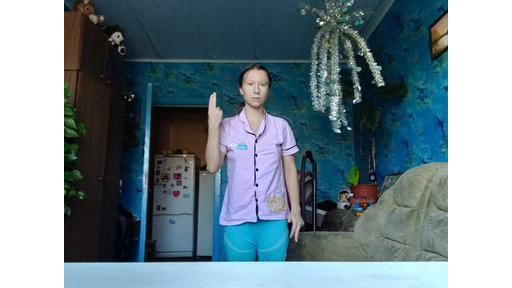

In [29]:
# Resize and pad the sample image to the desired input size, retrieving transformation data.
input_img, transform_data = resize_and_pad(sample_img, input_sz, True)

# Convert the resized and padded image into a NumPy array suitable for model input.
input_tensor_np = np.array(input_img, dtype=np.float32)[None] / 255

# Print the transformation data to understand how the image was resized and where it was placed.
print(f"transform_data: {transform_data}")

# Print the shape of the input tensor to verify it matches the expected input shape for the model.
# The shape is expected to be (batch_size, height, width, channels).
print(f"input_tensor_np.shape: {input_tensor_np.shape}")

# Display the resized and padded image.
input_img

#### Perform Inference with the Quantized Model

In [30]:
# Create an inference context for quantized model execution
with runner.infer_context(InferenceContext.SDK_QUANTIZED) as ctx:
    # Perform inference using the quantized model
    # input_tensor_np is assumed to be a pre-processed input image as a numpy array
    quantized_res = runner.infer(ctx, input_tensor_np)

# Print the shape of the inference results
print(quantized_res.shape)

Inference: 0entries [00:00, ?entries/s]2024-10-14 18:19:24.270858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Inference: 8entries [00:30,  3.84s/entries]

(1, 1, 24, 3024)


#### Process the Model Output

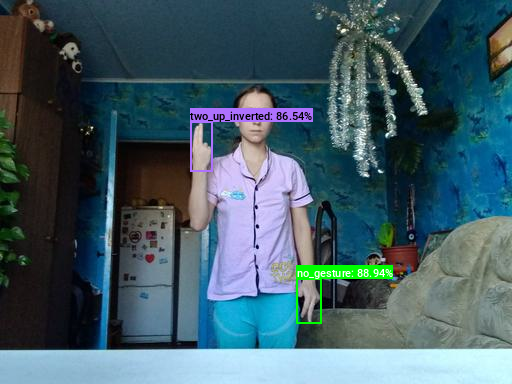

In [31]:
# Transpose and extract the first element of the quantized results
outputs = quantized_res.transpose(0, 1, 3, 2)[0]

# Process the outputs to generate initial object proposals
proposals = process_outputs(outputs, input_sz[::-1], 0.3)

# Apply non-max suppression (NMS) to remove overlapping bounding boxes
# Calculate Intersection over Union (IoU) for the proposals
iou_matrix = calc_iou(proposals[:, :-2])
# Apply NMS with a threshold of 0.45 to get indices of kept proposals
proposal_indices = nms_sorted_boxes(iou_matrix, 0.45)
# Keep only the proposals that passed NMS
proposals = proposals[proposal_indices]

# Prepare lists for bounding boxes, labels, and probabilities
bbox_list = [adjust_bbox(bbox, transform_data) for bbox in proposals[:,:4]]
label_list = [class_names[int(idx)] for idx in proposals[:,4]]
probs_list = proposals[:,5]

# Draw bounding boxes on the image
annotated_img = draw_bboxes_pil(
    image=sample_img,          # The original image
    boxes=bbox_list,           # List of bounding boxes
    labels=label_list,         # List of class labels for each box
    probs=probs_list,          # List of probabilities for each box
    colors=[int_colors[class_names.index(i)] for i in label_list],  # Colors for each box based on class
    font=font_file,            # Font file for text on the image
)

# Display the annotated image
display(annotated_img)

### Compilation

#### Compile the Quantized Model

In [32]:
# Initialize a Hailo Dataflow Compiler API Client
# This creates a runner object that will be used to compile the model
runner = ClientRunner(har=str(quantized_model_har_path))

# Compile the quantized model for the target Hailo hardware
# This step converts the model into a format that can run on Hailo accelerators
hef = runner.compile()

# Define the path for the compiled model
# We use the same directory and name as the original ONNX file, but change the extension to .hef
# 'hef' stands for Hailo Executable Format
compiled_model_hef_path = onnx_file_path.parent / f"{onnx_file_path.stem}.hef"

# Write the compiled model to a file
# We open the file in binary write mode ('wb') because HEF is a binary format
with open(compiled_model_hef_path, "wb") as f:
    f.write(hef)

[info] To achieve optimal performance, set the compiler_optimization_level to "max" by adding performance_param(compiler_optimization_level=max) to the model script. Note that this may increase compilation time.
[info] Loading network parameters
[info] Starting Hailo allocation and compilation flow
[info] Finding the best partition to contexts...
[info] Iteration #1 - Contexts: 4
[info] Iteration #2 - Contexts: 4
[info] Iteration #3 - Contexts: 4
[info] Iteration #4 - Contexts: 4
[info] Iteration #5 - Contexts: 4
[info] Iteration #6 - Contexts: 4
[info] Iteration #7 - Contexts: 4
[info] Iteration #8 - Contexts: 4
[info] Iteration #9 - Contexts: 4
[info] Iteration #10 - Contexts: 4
[info] Iteration #11 - Contexts: 4
[info] Iteration #12 - Contexts: 4
[info] Iteration #13 - Contexts: 4
[info] Iteration #14 - Contexts: 4
[info] Iteration #15 - Contexts: 4
[info] Iteration #16 - Contexts: 4
[info] Iteration #17 - Contexts: 4
[info] Iteration #18 - Contexts: 4
[info] Iteration #19 - Context

#### Run the Profiler Tool

In [33]:
# Define the path for the compiled model HAR file
compiled_model_har_path = onnx_file_path.parent / f"{onnx_file_path.stem}_compiled_model.har"

# Save the compiled model as a HAR file
runner.save_har(compiled_model_har_path)

# Run the Hailo profiler on the compiled model
subprocess.run(["hailo", "profiler", str(compiled_model_har_path)], check=True)

[info] Saved HAR to: /mnt/ACASIS_4TB/Projects/GitHub/pytorch-yolox-object-detection-tutorial-code/notebooks/pytorch-yolox-object-detector/2024-09-08_19-22-32/hagrid-sample-30k-384p-yolox_tiny_compiled_model.har
[info] Current Time: 18:24:13, 10/14/24
[info] CPU: Architecture: x86_64, Model: 11th Gen Intel(R) Core(TM) i7-11700K @ 3.60GHz, Number Of Cores: 16, Utilization: 1.8%
[info] Memory: Total: 31GB, Available: 14GB
[info] System info: OS: Linux, Kernel: 6.8.0-45-generic
[info] Hailo DFC Version: 3.29.0
[info] HailoRT Version: Not Installed
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo profiler pytorch-yolox-object-detector/2024-09-08_19-22-32/hagrid-sample-30k-384p-yolox_tiny_compiled_model.har`
[info] Running profile for hagrid-sample-30k-384p-yolox_tiny in state compiled_model
[info] 
Model Details
--------------------------------  ----------
Input Tensors Shapes              288x512x3
Operations per Input Tensor       5.43 GOPs
Operations per Input Tensor    

CompletedProcess(args=['hailo', 'profiler', 'pytorch-yolox-object-detector/2024-09-08_19-22-32/hagrid-sample-30k-384p-yolox_tiny_compiled_model.har'], returncode=0)